# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
import copy
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head(5) # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
#print(asl.df.ix[98,0])
asl.df.ix[107,5]  # look at the data available for an individual frame

left-x       209
left-y       239
right-x      162
right-y      237
nose-x       177
nose-y        62
speaker    man-1
Name: (107, 5), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of SELECTED features for a given (video, frame) tuple
[asl.df.ix[98,4][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
# here we are using "features_ground" as training features
training = asl.build_training(features_ground)
#train_word and test_word files have already got a format: video,speaker,word,startframe,endframe
#build_training extract those features
print("Training words: {}".format(training.words))
print(dir(training))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
####### TRAINING PLAY AROUND ########
# methods available for the "training" OBJ: 
# 'get_all_Xlengths', 'get_all_sequences', 'get_word_Xlengths', 'get_word_sequences',
# 'num_items' and 'words'
#dir(training)
d_word = 'CHOCOLATE'
X, lengths = training.get_word_Xlengths(d_word)
# print(X) #list of values of ground features related to that word; spread across videos
# print(len(X)) # value of ground features of frame of word "chocolates" in different video clips
# print(lengths) #spam of number of frames for a particular word
print()
# print(training.get_word_sequences(d_word)): basically it's all the X for a word
# there are features_ground values of corresponding sequence of FRAMES where the word chocolates appear; for example:
# [-11, 48, 7, 120] is values features_ground of  the occurance of "chocolate" in video 81 from frame 19 
# where 19 - 35 are all sequence of frames related to the word "chocolate" in video 81.
#training.words: list of words
#training.num_items: 112
#training.get_all_Xlengths()['JOHN']: dictionary; list of all values of features_ground of frames of that words;
# length is the duration (number) of frames for each sample of words
#training.get_all_sequences()['JOHN']: dictionary list of values of features_ground of frames of that words without
# length as the second output (basically just X)

#print(training.get_all_Xlengths()['JOHN'])
#print(training.get_all_sequences()['JOHN'])
print((training.get_all_sequences()['HOMEWORK'][0])) #total 113 frames about JOHN
print()
print(((training.get_all_Xlengths()['HOMEWORK'][1])))


[[-36, 46, 7, 59], [-40, 37, 7, 60], [-40, 31, 6, 64], [-40, 33, 5, 70], [-36, 29, 3, 71], [-32, 28, 3, 75], [-28, 24, 0, 78], [-25, 23, 2, 82], [-20, 21, -1, 83], [-17, 25, 0, 82], [-17, 26, -2, 79], [-12, 31, 0, 77], [-8, 36, -2, 71], [-3, 44, -2, 68], [0, 46, -1, 68], [-4, 48, -1, 73], [-2, 48, 2, 78], [-2, 51, 0, 77], [-2, 53, 1, 78], [-1, 56, -2, 77], [-2, 59, -4, 80], [-2, 63, -5, 84], [-4, 66, -5, 91], [-1, 72, -9, 98], [-1, 79, -14, 103], [1, 86, -12, 111], [3, 98, -18, 122]]

[27]


In [8]:
#t_restWords = copy.deepcopy(training.get_all_Xlengths())
#for v in restWords:
#    print(v)
#print(len(restWords))
#restWords.pop("JOHN")
#print(len(restWords))

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [9]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [10]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  left-y-mean  \
video frame                                                                 
98    0          113        9      119      -12   164.661438   161.271242   
      1          113        9      119      -12   164.661438   161.271242   
      2          113        9      119      -12   164.661438   161.271242   
      3          113        9      119      -12   164.661438   161.271242   
      4          113        9      119      -12   164.661438   161.271242   

             right-x-mean  right-y-mean  
video frame                              
98    0        151.017865    117.332462  
      1        151.017865    117.332462  
      2        151.017865    117.332462  
      3        151.017865    117.332462  
      4        151.017865    117.332462

##### Try it!

In [11]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean,left-y-mean,right-x-mean,right-y-mean
speaker,,,,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0,0.0,0.0,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0,0.0,0.0,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0,0.0,0.0,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [12]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean'])/asl.df['left-x-std'] 
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean'])/asl.df['left-y-std'] 
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean'])/asl.df['right-x-std'] 
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean'])/asl.df['right-y-std'] 


features_norm = ['norm-rx', 'norm-ry','norm-lx', 'norm-ly']

In [13]:
#np.sqrt(np.square(asl.df['grnd-ry']) + np.square(asl.df['grnd-rx']))

In [14]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-lr'] = np.sqrt(np.square(asl.df['grnd-ly']) + np.square(asl.df['grnd-lx']))
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

asl.df['polar-rr'] = np.sqrt(np.square(asl.df['grnd-ry']) + np.square(asl.df['grnd-rx']))
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

features_polar = ['polar-rr', 'polar-rtheta','polar-lr', 'polar-ltheta']

In [15]:
asl.df['polar-delta-lr'] = asl.df['polar-lr'].diff().fillna(1e-14)
asl.df['polar-delta-ltheta'] = asl.df['polar-ltheta'].diff().fillna(1e-14)
asl.df['polar-delta-rr'] = asl.df['polar-rr'].diff().fillna(1e-14)
asl.df['polar-delta-rtheta'] = asl.df['polar-rtheta'].diff().fillna(1e-14) 
    
features_polar_delta = ['polar-delta-lr', 'polar-delta-ltheta', 'polar-delta-rr', 'polar-delta-rtheta']

In [16]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" ...
# ... values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0) 
    
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [17]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# Part I: normalize scaling of polar features:
# update the mean value as we have more derived columns now
df_means = asl.df.groupby('speaker').mean()

asl.df['polar-lr-mean']= asl.df['speaker'].map(df_means['polar-lr'])
asl.df['polar-lr-mean-norm']= asl.df['polar-lr-mean']/(asl.df['polar-lr'].max()-asl.df['polar-lr'].min())

asl.df['polar-rtheta-mean']= asl.df['speaker'].map(df_means['polar-rtheta'])
asl.df['polar-rtheta-mean-norm']= asl.df['polar-rtheta-mean']/(asl.df['polar-rtheta'].max()-asl.df['polar-rtheta'].min())

asl.df['polar-rr-mean']= asl.df['speaker'].map(df_means['polar-rr'])
asl.df['polar-rr-mean-norm']= asl.df['polar-rr-mean']/(asl.df['polar-rr'].max()-asl.df['polar-rr'].min())

asl.df['polar-ltheta-mean']= asl.df['speaker'].map(df_means['polar-ltheta'])
asl.df['polar-ltheta-mean-norm']= asl.df['polar-ltheta-mean']/(asl.df['polar-ltheta'].max()-asl.df['polar-ltheta'].min())

#asl.df['polar-lr'].max()

# Part II: add new features:
asl.df['totalDelta-l'] = asl.df['delta-lx'] + asl.df['delta-ly']
asl.df['totalDelta-r'] = asl.df['delta-rx'] + asl.df['delta-ry']

df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

asl.df['totalDelta-l-mean']= asl.df['speaker'].map(df_means['totalDelta-l'])
asl.df['totalDelta-r-mean']= asl.df['speaker'].map(df_means['totalDelta-r'])

asl.df['totalDelta-l-std'] = asl.df['speaker'].map(df_std['totalDelta-l'])
asl.df['totalDelta-r-std'] = asl.df['speaker'].map(df_std['totalDelta-r'])

asl.df['totalDelta-l-norm'] = (asl.df['totalDelta-l'] - asl.df['totalDelta-l-mean'])/asl.df['totalDelta-l-std']
asl.df['totalDelta-r-norm'] = (asl.df['totalDelta-r'] - asl.df['totalDelta-r-mean'])/asl.df['totalDelta-r-std']

# TODO define a list named 'features_custom' for building the training set
features_custom1 = ['polar-lr-mean-norm', 'polar-rtheta-mean-norm','polar-rr-mean-norm','polar-ltheta-mean-norm']
features_custom2 = ['totalDelta-l-norm','totalDelta-r-norm']
features_custom3 = ['polar-lr-mean-norm', 'polar-rtheta','polar-rr-mean-norm','polar-ltheta']
features_custom4 = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly','polar-lr','polar-rr']

In [18]:
asl.df.head().columns

Index(['left-x', 'left-y', 'right-x', 'right-y', 'nose-x', 'nose-y', 'speaker',
       'grnd-ry', 'grnd-rx', 'grnd-ly', 'grnd-lx', 'left-x-mean',
       'left-y-mean', 'right-x-mean', 'right-y-mean', 'left-x-std',
       'left-y-std', 'right-x-std', 'right-y-std', 'norm-lx', 'norm-ly',
       'norm-rx', 'norm-ry', 'polar-lr', 'polar-ltheta', 'polar-rr',
       'polar-rtheta', 'polar-delta-lr', 'polar-delta-ltheta',
       'polar-delta-rr', 'polar-delta-rtheta', 'delta-lx', 'delta-ly',
       'delta-rx', 'delta-ry', 'polar-lr-mean', 'polar-lr-mean-norm',
       'polar-rtheta-mean', 'polar-rtheta-mean-norm', 'polar-rr-mean',
       'polar-rr-mean-norm', 'polar-ltheta-mean', 'polar-ltheta-mean-norm',
       'totalDelta-l', 'totalDelta-r', 'totalDelta-l-mean',
       'totalDelta-r-mean', 'totalDelta-l-std', 'totalDelta-r-std',
       'totalDelta-l-norm', 'totalDelta-r-norm'],
      dtype='object')

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
The first part is to use feature scaling to rescale the polar features created. This could hopefully reduce the error introduced by difference in scale of different features.

The second part is a new feature by adding the delta of x and delta of y together. We know already from the lecture that deltaX is a better choice than deltaY. But even with just deltaY a model can be trained to identify sign language. Hence both deltaX and deltaY carry information about that could assist the recognition of sign language. Combining these 2 variables could potentially allow us to access information from these 2 variables through one single variable.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [19]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.032s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [20]:
import warnings
from hmmlearn.hmm import GaussianHMM

warnings.filterwarnings('ignore')

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths) #fit: iterative
    logL = model.score(X, lengths)
    return model, logL

demoword = 'HOMEWORK'
model, logL = train_a_word(demoword, 5, features_polar) #features_custom
#model, logL = train_a_word(demoword, 3, features_custom)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))
#n = 3 logL = -663; n = 20: logL= -191

Number of states trained in model for HOMEWORK is 5
logL = -80.96552304136762


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [21]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for HOMEWORK is 5
hidden state #0
mean =  [ 50.70051299  -0.83755841  66.7163006    0.08027154]
variance =  [  2.70054647e+01   8.49951391e-03   3.32164099e+01   2.67947843e-03]

hidden state #1
mean =  [  8.69351436e+01   8.72378797e-03   1.12274672e+02  -1.27916490e-01]
variance =  [  7.01195046e+01   3.49855138e-03   7.00942185e+01   3.49356308e-03]

hidden state #2
mean =  [  3.30598226e+01  -6.02594393e-01   7.88604599e+01  -5.75973472e-03]
variance =  [  8.56083260e+00   5.07610455e-02   1.46659582e+01   1.70661663e-03]

hidden state #3
mean =  [  5.03106365e+01  -4.04850402e-02   7.46725369e+01  -1.02377828e-02]
variance =  [  2.06389744e+01   1.93033289e-03   1.88477576e+01   1.77755480e-03]

hidden state #4
mean =  [  6.59635626e+01  -3.62301278e-02   8.97064510e+01  -6.55662395e-02]
variance =  [  1.76784209e+01   3.46131651e-03   4.05093750e+01   3.39244937e-03]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [22]:
#my_testword = 'BOOK'
my_testword = 'HOMEWORK'
model, logL = train_a_word(my_testword, 4, features_polar_delta) # features_polar_delta
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
#features_norm 'BOOK' 2 logL = -258.4535818619689
#features_norm 'BOOK' 3 logL = -130.71089221940207
#features_norm 'BOOK' 4 logL = -16.68677023386519
#features_norm 'BOOK' 5 logL = 66.43193997618243
#features_norm 'BOOK' 6 logL = 87.5373149037784
#features_norm 'BOOK' 7 logL = 137.3849462554619

#features_norm 'CHOCOLATE' 2 logL = -12.24148077728365
#features_norm 'CHOCOLATE' 3 logL = 22.651977224475267
#features_norm 'CHOCOLATE' 4 logL = 85.72111948347717
#features_norm 'CHOCOLATE' 5 logL = 103.40377777857125
#features_norm 'CHOCOLATE' 6 logL = 121.87304943997314
#features_norm 'CHOCOLATE' 7 logL = 175.03106955314013

#features_delta 'CHOCOLATE' 3 -256.56151832675334
#features_delta 'CHOCOLATE' 3 -59.11265717009594}

Number of states trained in model for HOMEWORK is 4
hidden state #0
mean =  [-1.75703417 -0.00612201  2.77643509  0.0867039 ]
variance =  [  3.78636158e+00   1.60018480e-03   3.15853930e+00   7.03210493e-03]

hidden state #1
mean =  [  4.44538547e+00   2.38547663e-03   2.26049283e+00  -1.50641698e-02]
variance =  [ 0.99567478  0.00298085  2.23617287  0.00444539]

hidden state #2
mean =  [ 2.50763229 -0.01421841 -3.13414874 -0.0319883 ]
variance =  [  4.18409615e+00   1.50565727e-03   6.14249829e+00   8.85924031e-03]

hidden state #3
mean =  [ 7.79275321 -0.01822756  7.11584066  0.01410636]
variance =  [  4.58686807e+00   2.84650931e-03   8.07866905e+00   2.62193958e-03]

logL = -32.630819746834206


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [23]:
%matplotlib inline

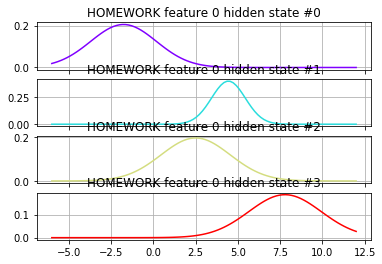

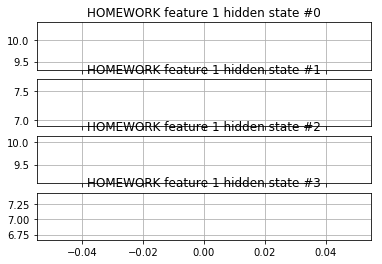

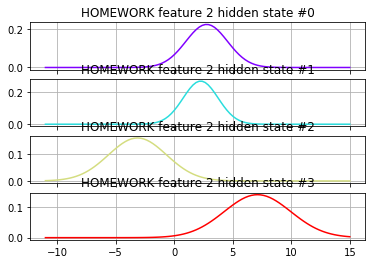

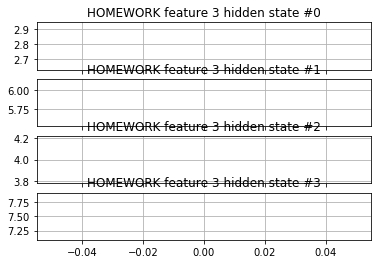

In [24]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [25]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words # training.words gets all the words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [26]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'EAT' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
print(len(word_sequences))
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

5
Train fold indices:[2 3 4] Test fold indices:[0 1]
Train fold indices:[0 1 4] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4]


In [27]:
from asl_utils import combine_sequences

for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    combined_seq_X, grouping_Length = combine_sequences(cv_train_idx, word_sequences)

#split_method.split(word_sequences)
print(len(combined_seq_X))
print(grouping_Length)
print(word_sequences[1])

36
[11, 4, 11, 10]
[[-20, 51, 32, 88], [-20, 42, 31, 89], [-20, 42, 27, 89], [-19, 38, 27, 89]]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [28]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN', 'HOMEWORK']
import timeit

In [29]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [30]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.23748363833874464 seconds
Training complete for BOOK with 5 states with time 2.5772476461715996 seconds
Training complete for VEGETABLE with 2 states with time 1.0230987151153386 seconds
Training complete for FUTURE with 2 states with time 2.753534364979714 seconds
Training complete for JOHN with 7 states with time 23.27265905868262 seconds
Training complete for HOMEWORK with 9 states with time 0.24969411082565784 seconds


In [31]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Null Model Found! FISH
Training complete for FISH with 10 states with time 0.034062480088323355 seconds
Null Model Found! BOOK
Training complete for BOOK with 10 states with time 0.18310172436758876 seconds
Null Model Found! VEGETABLE
Training complete for VEGETABLE with 10 states with time 0.089744389988482 seconds
Null Model Found! FUTURE
Training complete for FUTURE with 10 states with time 0.33133657509461045 seconds
Null Model Found! JOHN
Training complete for JOHN with 10 states with time 1.693230092059821 seconds
Null Model Found! HOMEWORK
Training complete for HOMEWORK with 10 states with time 0.03823898592963815 seconds


In [32]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.1636578720062971 seconds
Training complete for BOOK with 8 states with time 2.7027664119377732 seconds
Training complete for VEGETABLE with 10 states with time 1.9713397906161845 seconds
Training complete for FUTURE with 10 states with time 2.7106000827625394 seconds
Training complete for JOHN with 10 states with time 13.406952614896 seconds
Training complete for HOMEWORK with 8 states with time 1.5704083070158958 seconds


In [33]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_polar_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.828197262249887 seconds
Training complete for BOOK with 10 states with time 4.435523606836796 seconds
Training complete for VEGETABLE with 8 states with time 2.504363519139588 seconds
Training complete for FUTURE with 8 states with time 3.1332501913420856 seconds
Training complete for JOHN with 10 states with time 22.869274217169732 seconds
Training complete for HOMEWORK with 4 states with time 1.2706919689662755 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**<BR>
For the features "features_ground" chosen, SelectorCV tends to choose a more complicated (higher number of states). This might potentially make the training and prediction slower to run. The function of Kfold inside SelectorCV attempts to reduce overfitting by separating training and test sets. However for those words with fewer samples or shorter sequence, doing Kfold might hurt the training itself as there is already not enough samples/data to support the training.
<P>
SelectorBIC seems to be the fastest to run among these 3 selectors. Instead of using Kfold, BIC directly penalize the performance of a selector by second term p * log(N) where p is the of free parameters which in turns depends on number of states. Hence, as we can see in the suggested number of states for "features_ground" is much fewer than that made by SelectorCV
.<P>
SelectorDIC attempts to solve overfitting by encouraging a model that works not just for one particular word under training but also performs not too badly for other words. The training time hence depends also on number of total words we have and hence could be slow. Also it does not address the number of parameters issue and hence result model tend to be more complicated (all of the 5 words resulted in 15 states).


<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [34]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

.

Null Model Found! FRANK
Null Model Found! VEGETABLE


...
----------------------------------------------------------------------
Ran 4 tests in 80.443s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [35]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector, max_n = 12):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, min_n_components=2, max_n_components=max_n).select()
        model_dict[word]=model
    return model_dict

In [36]:
models = train_all_words(features_polar, SelectorDIC)
print("Number of word models returned = {}".format(len(models)))

Null Model Found! FIND
Null Model Found! SAY-1P
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [37]:
test_set = asl.build_test(features_polar)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [38]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors
from my_model_selectors import SelectorCV, SelectorBIC, SelectorDIC

In [39]:
# TODO Choose a feature set and model selector and optimal max n component
featuresList = [features_polar, features_polar_delta] #features_polar_delta
#[features_ground, features_norm, features_polar, features_delta, features_polar_delta]
modelSelectorList = [SelectorDIC]
#[SelectorCV, SelectorBIC, SelectorDIC]
max_n_list = [10,11,12,13,14,15,16]
bestModelSelector = None
bestFeature = None
bestMaxN = 0
lowestWERUniGram = 100.0

for ms in modelSelectorList:
    for f in featuresList:
        for mn in max_n_list:
            models_cand = train_all_words(f, ms, mn)
            test_set = asl.build_test(f)
            probabilities, guesses = recognize(models_cand, test_set)
            print("")
            print("Results for: {} {} {}".format(ms, f, mn))

            this_WER = show_errors(guesses, test_set, show_answer=False)
            if this_WER < lowestWERUniGram: # the lower the WER the better
                lowestWERUniGram = this_WER
                bestModelSelector = ms
                bestFeature = f
                bestMaxN = mn

print("Best features {} with selector {} and  n {} resulting in  WER: {}.".format(bestFeature, bestModelSelector, 
                                                                    bestMaxN, lowestWERUniGram))
print("")
        
####################################################

Null Model Found! FIND
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorDIC'> ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] 10

**** WER = 0.5280898876404494

Null Model Found! FIND
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorDIC'> ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] 11

**** WER = 0.5393258426966292

Null Model Found! FIND
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorDIC'> ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] 12

**** WER = 0.5056179775280899

Null Model Found! FIND
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorDIC'> ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] 13

**** WER = 0.5224719101123596

Null Model Found! FIND
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorDIC'> ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] 14

**** WER = 0.5280898876404494

Null Model Found! FIND
Nu

In [79]:
# TODO Choose a feature set and model selector and optimal max n component
featuresList = [features_polar, features_polar_delta] #features_polar_delta
#[features_ground, features_norm, features_polar, features_delta, features_polar_delta]
modelSelectorList = [SelectorCV, SelectorBIC, SelectorDIC]
max_n_list = [bestMaxN]
bestModelSelector = None
bestFeature = None
bestMaxN = 0
lowestWERUniGram = 100.0

for ms in modelSelectorList:
    for f in featuresList:
        for mn in max_n_list:
            models_cand = train_all_words(f, ms, mn)
            test_set = asl.build_test(f)
            probabilities, guesses = recognize(models_cand, test_set)
            print("")
            print("Results for: {} {} {}".format(ms, f, mn))

            this_WER = show_errors(guesses, test_set, show_answer=False)
            if this_WER < lowestWERUniGram: # the lower the WER the better
                lowestWERUniGram = this_WER
                bestModelSelector = ms
                bestFeature = f
                bestMaxN = mn

print("Best features {} with selector {} and  n {} resulting in  WER: {}.".format(bestFeature, bestModelSelector, 
                                                                    bestMaxN, lowestWERUniGram))
print("")
        
####################################################

Null Model Found! FIND
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorCV'> ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] 12

**** WER = 0.651685393258427

Null Model Found! ANN
Null Model Found! LEG
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorCV'> ['polar-delta-lr', 'polar-delta-ltheta', 'polar-delta-rr', 'polar-delta-rtheta'] 12

**** WER = 0.601123595505618

Null Model Found! JOHN
Null Model Found! WRITE
Null Model Found! HOMEWORK
Null Model Found! IX-1P
Null Model Found! SEE
Null Model Found! YESTERDAY
Null Model Found! IX
Null Model Found! LOVE
Null Model Found! MARY
Null Model Found! CAN
Null Model Found! GO
Null Model Found! GO1
Null Model Found! FUTURE
Null Model Found! GO2
Null Model Found! PARTY
Null Model Found! FUTURE1
Null Model Found! HIT
Null Model Found! BLAME
Null Model Found! FRED
Null Model Found! FISH
Null Model Found! WONT
Null Model Found! EAT
Null Model Found! BUT
Null Model Found! CHICKEN
Null Mo

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
<TABLE border=1 width=50%>
<TR><TD>Feature</TD><TD>Selector</TD><TD>WER</TD></TR>
<TR><TD>features_polar</TD><TD>SelectorCV</TD><TD>0.6516</TD></TR>
<TR><TD>features_polar_delta</TD><TD>SelectorCV</TD><TD>0.6011</TD></TR>
<TR><TD>features_polar</TD><TD>SelectorBIC</TD><TD>0.5449</TD></TR>
<TR><TD>features_polar_delta</TD><TD>SelectorBIC</TD><TD>0.6179</TD></TR>
<TR bgcolor="#7FFFD4"><TD>features_polar</TD><TD>SelectorDIC</TD><TD>0.5168</TD></TR>
<TR><TD>features_polar_delta</TD><TD>SelectorDIC</TD><TD>0.5898</TD></TR>
</TABLE><P>

Among all selectors, it seems that SelectorDIC, while takes a longer time to train, come up with the highest accuracy. It scored the highest on "features_polar" and "features_polar_delta". 
<P>
Regarding the custom features, the first attempt was to normalize both polar coordinates and the angles. But since angles has already got a limited range, normalizing it did not improve accuracy. By just normalizing the coordinates using witha combination or unnormalized angles, we got a better result even they are less satisfactory compared to other features.
<P>
Possible improvements:
<UL>
<LI>Possibly mix and match some of the components of different selector. For example, we might want to try applying Kfold to BIC as BIC's selector involves only samples of one word and it could be possible to apply Kfold.
<LI>Collect more data as some words have very limited samples.
<LI>Possibly consider increasing the max limits of number of states. While SelectorBIC tends to choose the more complicated model, it is however the best performing in terms of accuracy. Currently it seems that it is limited by the maximum number of states allowed.
<LI>Consider training on combination of words like SUBJECT + VERB OR VERB + OBJECT as connecting words might affect the ASL guestures of one another
</UL>

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [44]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 41.537s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [45]:
########################################## EXPERIMENT STARTS BELOW ############################################

In [46]:
bestModelSelector, bestFeature, bestMaxN

(my_model_selectors.SelectorDIC,
 ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'],
 12)

In [50]:
import warnings
warnings.filterwarnings('ignore')

# STEP !: 
# Based on the best selector/features, get the logL highest probabilities for test set
# we need "probabilities" for future calculation

#bestModelSelector = SelectorDIC
#bestFeature = features_polar

models = train_all_words(bestFeature, bestModelSelector, bestMaxN)
test_set = asl.build_test(bestFeature) #default use 'test_words.csv'

LMprobabilities, LMguesses = recognize(models, test_set)
print("")
print("Results for: {} {} {}".format(bestModelSelector, bestFeature, bestMaxN))
LMBaseLineWER = show_errors(LMguesses, test_set, show_answer = True)

Null Model Found! FIND
Null Model Found! SAY-1P

Results for: <class 'my_model_selectors.SelectorDIC'> ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] 12

**** WER = 0.5

Total correct: 89 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *ARRIVE *JOHN *FUTURE *GIVE1 *WHAT *FUTURE *WHO          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *WHO IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *MARY *MARY                                    JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE

In [51]:
#### play around with "probabilities"
assert(len(test_set.wordlist) == len(LMprobabilities)) # 178 

print(models['HOMEWORK']) 

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=7, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)


<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [52]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=LMprobabilities)

assert(len(test_set.wordlist) == len(df_probs)) #178 words; 40 sentences
assert(len(training.words) == len(df_probs.columns)) #112

In [53]:
#df_probs plays around
df_probs.ix[2].head()

ALL      -9.576855e+03
ANN      -2.520507e+06
APPLE    -1.622638e+04
ARRIVE   -3.320226e+02
BILL     -2.565561e+04
Name: 2, dtype: float64

In [54]:
#debugging/try and error area
df_probs.ix[0]['GO'] #first word VS APPLE

-248.76512547689032

In [55]:
import arpa
models_1G = arpa.loadf("ngrams_data/devel-lm-M1.sri.lm")
models_3G = arpa.loadf("ngrams_data/devel-lm-M3.sri.lm")

lm = models_3G[0]  # ARPA files may contain several models.

In [56]:
#arpa playaround
try:
    logL = lm.log_p("JOHN BOOK")
    print(logL)
except KeyError:
    print("key error")


-1.9180998999999999


In [57]:
test_set.wordlist[test_set.sentences_index[2][0]]
#lm.log_p("MARY BUY1")

'JOHN'

In [58]:
#wordsCombinationList = generateWordsCombination(2)
#len(wordsCombinationList)

In [59]:
def getJointProb(candList, ModelNGram = models_3G, method = "JointOnly", isFullSent = False):
    
    tmp_candList = copy.deepcopy(candList)

    tmp_candList.insert(0, '<s>')
    if isFullSent:
        tmp_candList.append('</s>')

    LMlogL3Gram_element = 1e-99

    for ci in range(0,len(tmp_candList)+1): 
        eval_str = " ".join(tmp_candList[max(0,ci-3):ci])
        if eval_str != '<s>':
            try:
                #print(eval_str)
                LMlogL3Gram_element = LMlogL3Gram_element + lm.log_p(eval_str) #cummulative prob
            except:
                LMlogL3Gram_element = LMlogL3Gram_element + 1e-99

    if method == "JointOnly":
        logL3GramJoint = LMlogL3Gram_element/(len(tmp_candList)+1)
    else:
        try:
            LMlogL = lm.log_p(" ".join(tmp_candList))
        except:
            LMlogL = 1e-99

        logL3GramJoint = (LMlogL + LMlogL3Gram_element)/(len(tmp_candList) + 2)
                  
    return logL3GramJoint

In [60]:
def recognize_ngrams3(test_set, df_probs, ModelNGram = models_3G, beta = 1.0, method = "JointOnly"):
    bestGuessWordList = []

    for si in test_set.sentences_index: #loop thru all sentences: [0, 1, 2], [3, 4, 5, 6]
        tempSentenceWord = []
        for i in range(len(test_set.sentences_index[si])):

            word_index = test_set.sentences_index[si][i]
            truth_word = test_set.wordlist[word_index] #for debugging only!

            zeroG_logL = float("-Inf")
            uniG_logL = 1e-99
            bestTotalLogL = float("-Inf")
            bestWord = ""
            
            for cand_index in range(len(df_probs.columns)):
                cand_word = df_probs.columns[cand_index]
                
                zeroG_logL = df_probs.ix[word_index][cand_index] #read logL from table
                
                candList = copy.deepcopy(tempSentenceWord)
                candList.append(cand_word)
             
                logL3GramJoint = getJointProb(candList, isFullSent = (len(test_set.sentences_index[si])-1) == i, 
                                             method = method)
                """
                try:
                    logL3GramJoint = lm.log_s(candList)
                except:
                    logL3GramJoint = 1e-99
                
                """   
                total_logL = zeroG_logL + beta * logL3GramJoint
                #print(beta)

                if total_logL > bestTotalLogL:
                    bestTotalLogL = total_logL
                    bestWord = cand_word

                #print(tempSentenceWord, cand_word, total_logL, zeroG_logL, logL3GramJoint)

            # finished one word   
            #print(truth_word, bestWord)
            bestGuessWordList.append(bestWord)
            tempSentenceWord.append(bestWord)

    return bestGuessWordList

In [61]:
#DEBUG: test if the function returns the same value if beta = 0
n3GramGuessWordList = recognize_ngrams3(test_set, df_probs, beta=0)
n3GramWER = show_errors(n3GramGuessWordList, test_set)
assert(n3GramWER == LMBaseLineWER)

print(n3GramWER, LMBaseLineWER)


**** WER = 0.5

0.5 0.5


In [62]:
# identify the optimal beta value
bestWER = 100.0
bestBeta = 0.0
betaRecord = []
WERRecord = []
best3GramGuessWordList = []

for b in range(0,100):
    n3GramGuessWordList = recognize_ngrams3(test_set, df_probs, beta=b, method = "JointOnly")
    thisWER = show_errors(n3GramGuessWordList, test_set, show_WER=False)
    print("Running beta: {} and WER: {}".format(b, thisWER), end='\r')
    if thisWER < bestWER: #the smaller the WER value the better
        bestWER = thisWER
        bestBeta = b
        best3GramGuessWordList = n3GramGuessWordList
    betaRecord.append(b)
    WERRecord.append(thisWER)
    
print("Best Beta: {} with WER {}".format( bestBeta, bestWER))

Best Beta: 34 with WER 0.47191011235955055945


In [63]:
best3GramGuessTotal = recognize_ngrams3(test_set, df_probs, beta=bestBeta, method = "JointOnly")
thisWER = show_errors(best3GramGuessTotal, test_set, show_WER=True, show_answer=True)


**** WER = 0.47191011235955055

Total correct: 94 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN CAN *JOHN CAN                                            JOHN CAN GO CAN
   21: JOHN *GIVE1 *GIVE1 *FUTURE *GIVE1 *WHAT *FUTURE *WHO          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *WHO IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE         

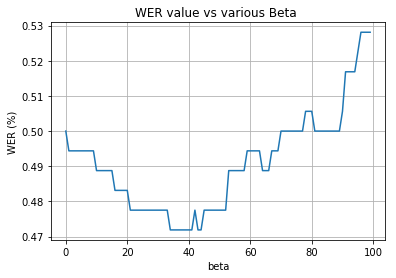

In [64]:
#Plot the graph of optimal beta resulting in lowest WER
fig, ax = plt.subplots()
ax.plot(betaRecord, WERRecord)

ax.set(xlabel='beta', ylabel='WER (%)',
       title='WER value vs various Beta ')
ax.grid()

#fig.savefig("test.png")
plt.show()

In [65]:
# NOW we have the best beta, the best model and the best features
# what are the difference of guesses between best Beta and simple LM
# show result with best BETA!

best3GramGuessTotal = recognize_ngrams3(test_set, df_probs, beta=bestBeta)

for i in range(len(best3GramGuessTotal)):
    if best3GramGuessTotal[i] != LMguesses[i]:
        print(best3GramGuessTotal[i], LMguesses[i] ,test_set.wordlist[i])
        
show_errors(best3GramGuessTotal, test_set, show_answer = True)
show_errors(LMguesses, test_set)

CAN WHAT CAN
GIVE1 ARRIVE FISH
GIVE1 JOHN WONT
JOHN IX JOHN
GO JOHN IX
IX WOMAN GIVE
MARY WHO CANDY
BUY1 ARRIVE BUY
JOHN MARY JOHN
JOHN IX JOHN
GIVE HAVE GIVE
JOHN LOVE IX-1P

**** WER = 0.47191011235955055

Total correct: 94 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN CAN *JOHN CAN                                            JOHN CAN GO CAN
   21: JOHN *GIVE1 *GIVE1 *FUTURE *GIVE1 *WHAT *FUTURE *WHO          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *WHO IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY              

0.5

## Conclusion for Part I:
### Simple HMM model achieve best with "features polar" and n-max of 12 is WER: 50%
Without using any language model to take probability of occurence into account, the best WER is around 50%. A few different parameters of n-max value has been tried. Best features identified so far is "features polar". The problem here is that probability of occurence has not been taken into consideration. So we proceed to part II.

## Conclusion for Part II:
### By simply adding LM proabability to HMM logL, the best we can do is WER 47.1%
With a weighted average between logL from HMM and LM (a beta of 34 in this case, we are able to further down the WER to 47.1%. While this method take into consideration or probability of occurence, this method consider only left to right occurrence. That is when evaluating the probability of the later part of a sentense, we assumed that the first part is fixed and will not be changed. That could be problematic. That's why we have part III.

In [66]:
# The recursion function

def generateCombinations(masterList, appendedList, sent_seq, slotIndex, maxLength, threhold, df_probs):
    if slotIndex < maxLength:
        wi = sent_seq[slotIndex]
        wordTopCandidatesList = list(df_probs.ix[wi].sort_values(ascending=False).head(threhold).index)
        for w in wordTopCandidatesList:
            appendedList1 = copy.deepcopy(appendedList)
            appendedList1.append(w)
            masterList = generateCombinations(masterList, appendedList1, sent_seq, slotIndex+1, 
                                              maxLength, threhold, df_probs)
            #masterList.append(resultList)
        return masterList
    else:
        masterList.append(appendedList)
        return masterList


In [67]:
# generate all combination of sentence based on top logL from LM
# and store the result in local JSON file masterListJSON
import json

masterListJSON = {}
#maxThrehold = 100 #5 is almost max given the memory of this machine
#maxThrehold = len(df_probs.columns)

count = 0
for si in test_set.sentences_index: #for each sentence
#si in values 2, 7 , 12 etc; sentences_index is a dict
    #if si == 2:
    #####
    #si=2 #

    sent_seq = test_set.sentences_index[si] #seq in form like [0, 1, 2] where number is word index
    print("Processing sentence: {}".format(count+1), end='\r')

    maxLength = len(sent_seq)
    slotIndex = 0
    masterList = []
    appendedList = []

    if maxLength <= 3:
        maxThrehold = 15
    elif maxLength > 3 and maxLength <= 5:
        maxThrehold = 10 #10
    else:
        maxThrehold = 5


    masterList = generateCombinations(masterList, appendedList, sent_seq, slotIndex, 
                                      maxLength, maxThrehold, df_probs)

    masterListJSON[str(si)] = masterList
    count +=1
    #####

assert(len(masterListJSON) == len(test_set.sentences_index))

#write to JSON file for future access
with open('combintation.json', 'w') as outfile:
    json.dump(masterListJSON, outfile)

In [68]:
# Check if the combinations generated are correct
#df_probs.ix[0].sort_values(ascending=False).head(3)
#df_probs.ix[1].sort_values(ascending=False).head(3)
#df_probs.ix[2].sort_values(ascending=False).head(3)

len(masterListJSON)

#for tc in masterListJSON['2']:
#    if tc[1] == 'WRITE' and tc[2] == 'HOMEWORK':
#        print(tc)

40

In [69]:
#for comparison and debugging
show_errors(LMguesses, test_set, show_WER = True, show_answer = True)


**** WER = 0.5

Total correct: 89 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *ARRIVE *JOHN *FUTURE *GIVE1 *WHAT *FUTURE *WHO          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *WHO IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *MARY *MARY                                    JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *JOHN *GIVE *JOHN *MARY                                  JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE                         

0.5

In [70]:
#Re-evaluate the best guesses based on complete sentence logL and logL3GramJoint

def evaluateTotalSentenceProb(masterListJSON, test_set, df_probs, lm, beta1 = 0, beta2 = 1, method = "JointOnly"):
    
    TotalSentProbGuess = []
    for si in masterListJSON:
    #for si in test_set.sentences_index:
        #if si == '2':
        maxTotal_logL = float("-Inf")
        bestCand = None

        for candList in masterListJSON[str(si)]: #cand like ['JOHN', 'MARY', 'HOMEWORK']
            #Part I HMM logL
            logL = 0.0
            for i in range(len(candList)):
                assert(len(test_set.sentences_index[int(si)]) == len(candList))
                wi = test_set.sentences_index[int(si)][i]
                logL += df_probs.ix[wi][candList[i]] #need to update i for different sentence!

            #Part II LM LMlogL
            LMlogL = -1e99

            # Calculate Joint Prob
            logL3GramJoint = getJointProb(candList, isFullSent=True, method = method)

            """
            try:
                logL3GramJoint = lm.log_s(candList)
            catch:
                logL3GramJoint = 1e-99
            """            

            totalLogL = beta1 * logL + beta2 * logL3GramJoint #Use joint prob instead

            if totalLogL > maxTotal_logL:
                maxTotal_logL = totalLogL
                bestCand = candList

            #if si =='7':
            #    print(candStr, maxTotal_logL, totalLogL, logL, LMlogL)  

        print(si, bestCand, maxTotal_logL, beta1, beta2)

        assert(len(test_set.sentences_index[int(si)]) == len(bestCand))

        for w in bestCand:
            TotalSentProbGuess.append(w)
        ####################################
    
    return TotalSentProbGuess
    

In [78]:
#debug by using beta2 = 0 we should expect to get the ordinary logL result
TotalSentProbGuess = evaluateTotalSentenceProb(masterListJSON, test_set, 
                                               df_probs, lm, beta1 = 0.5, beta2 = 120)
tWER = show_errors(TotalSentProbGuess, test_set, show_answer = True) 

2 ['JOHN', 'GIVE1', 'GIVE1'] -289.924484369 0.5 120
7 ['JOHN', 'CAN', 'GO', 'CAN'] -238.510820492 0.5 120
12 ['JOHN', 'GIVE1', 'GIVE1', 'CAN'] -195.69876786 0.5 120
21 ['JOHN', 'GIVE1', 'GIVE1', 'WHO', 'GIVE1', 'WHAT', 'GIVE1', 'WHO'] -355.018049704 0.5 120
25 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -206.160990516 0.5 120
28 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -217.840469455 0.5 120
30 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -143.39360312 0.5 120
36 ['IX', 'IX', 'IX', 'IX', 'IX', 'IX'] -320.903271461 0.5 120
40 ['JOHN', 'IX', 'GIVE', 'VISIT', 'MARY'] -219.062564773 0.5 120
43 ['JOHN', 'FUTURE', 'BUY', 'HOUSE'] -165.060420395 0.5 120
50 ['JOHN', 'SEE', 'GIVE1', 'GIVE1', 'JOHN'] -215.282584095 0.5 120
54 ['JOHN', 'FUTURE', 'NOT', 'BUY', 'HOUSE'] -133.897433531 0.5 120
57 ['JOHN', 'GO', 'VISIT', 'MARY'] -230.529090528 0.5 120
67 ['JOHN', 'FUTURE', 'NOT', 'BUY', 'HOUSE'] -205.783167299 0.5 120
71 ['JOHN', 'FUTURE', 'GIVE1', 'MARY'] -209.829573928 0.5 120
74 ['JOHN', 'GO', 'VISIT', 'MARY'] -204.429271

In [72]:
#playaround working buffer zone
#lm.log_p("JOHN GIVE IX SOMETHING-ONE WOMAN BOOK")

#playaround working buffer zone
#test_set.sentences_index[7][0]

#playaround working buffer zone
#df_probs.ix[5].sort_values(ascending=False)

In [76]:
#find out the optimal value for beta1, beta2
bestTSentWER = 100.0
bestBeta1 = 0
bestBeta2 = 0
testList1 = [0.5]
testList2 = [110, 115, 120, 125]
methodList = ["JointOnly"]
WERRecord = []
beta1Record = []
beta2Record = []

for m in methodList:
    for b1 in testList1:
        for b2 in testList2:
            TotalSentProbGuess = evaluateTotalSentenceProb(masterListJSON, test_set, df_probs, lm, 
                                                           beta1 = b1, beta2 = b2, method = m)
            tWER = show_errors(TotalSentProbGuess, test_set, show_answer = False, show_WER = False) 
            print("b1: {} b2: {} method: {} WER: {}". format(b1, b2, m, tWER) ,end="\n\n")
            if tWER < bestTSentWER:
                bestTSentWER = tWER
                bestBeta1 = b1
                bestBeta2 = b2
                bestMethod = m
            WERRecord.append(tWER)
            beta1Record.append(b1)
            beta2Record.append(b2)

print(bestTSentWER, bestBeta1, bestBeta2, m)

2 ['JOHN', 'GIVE1', 'GIVE1'] -287.996213536 0.5 110
7 ['JOHN', 'CAN', 'GO', 'CAN'] -234.953862064 0.5 110
12 ['JOHN', 'GIVE1', 'GIVE1', 'CAN'] -191.237089002 0.5 110
21 ['JOHN', 'GIVE1', 'GIVE1', 'WHO', 'GIVE1', 'WHAT', 'GIVE1', 'WHO'] -350.489574522 0.5 110
25 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -201.150650766 0.5 110
28 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -212.830129705 0.5 110
30 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -138.38326337 0.5 110
36 ['IX', 'VISIT', 'GIVE', 'JOHN', 'LOVE', 'MARY'] -311.398272849 0.5 110
40 ['JOHN', 'IX', 'GIVE', 'VISIT', 'MARY'] -212.41592306 0.5 110
43 ['JOHN', 'FUTURE', 'BUY', 'HOUSE'] -160.461250724 0.5 110
50 ['JOHN', 'SEE', 'GIVE1', 'GIVE1', 'JOHN'] -210.17912797 0.5 110
54 ['JOHN', 'FUTURE', 'NOT', 'BUY', 'HOUSE'] -130.177436319 0.5 110
57 ['JOHN', 'GO', 'VISIT', 'MARY'] -225.124269242 0.5 110
67 ['JOHN', 'FUTURE', 'NOT', 'BUY', 'HOUSE'] -202.063170087 0.5 110
71 ['JOHN', 'FUTURE', 'GIVE1', 'MARY'] -205.505837071 0.5 110
74 ['JOHN', 'GO', 'VISIT', 'MARY'] -

In [229]:
#Moethod 1 lowest
#0.46629213483146065 0.5 100
#0.47191011235955055 0.1 10 JointAndCondition maxthrehold 10
#0.43820224719101125 0.7 100 JointOnly
#0.43820224719101125 0.7 100 JointOnly
#0.43258426966292135 0.5 120 JointOnly

In [77]:
TotalSentProbGuess = evaluateTotalSentenceProb(masterListJSON, test_set, df_probs, lm, 
                                               beta1 = bestBeta1, beta2 = bestBeta2, method = bestMethod)
tWER = show_errors(TotalSentProbGuess, test_set, show_answer = True, show_WER = True) 

2 ['JOHN', 'GIVE1', 'GIVE1'] -289.924484369 0.5 120
7 ['JOHN', 'CAN', 'GO', 'CAN'] -238.510820492 0.5 120
12 ['JOHN', 'GIVE1', 'GIVE1', 'CAN'] -195.69876786 0.5 120
21 ['JOHN', 'GIVE1', 'GIVE1', 'WHO', 'GIVE1', 'WHAT', 'GIVE1', 'WHO'] -355.018049704 0.5 120
25 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -206.160990516 0.5 120
28 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -217.840469455 0.5 120
30 ['JOHN', 'LIKE', 'IX', 'IX', 'IX'] -143.39360312 0.5 120
36 ['IX', 'IX', 'IX', 'IX', 'IX', 'IX'] -320.903271461 0.5 120
40 ['JOHN', 'IX', 'GIVE', 'VISIT', 'MARY'] -219.062564773 0.5 120
43 ['JOHN', 'FUTURE', 'BUY', 'HOUSE'] -165.060420395 0.5 120
50 ['JOHN', 'SEE', 'GIVE1', 'GIVE1', 'JOHN'] -215.282584095 0.5 120
54 ['JOHN', 'FUTURE', 'NOT', 'BUY', 'HOUSE'] -133.897433531 0.5 120
57 ['JOHN', 'GO', 'VISIT', 'MARY'] -230.529090528 0.5 120
67 ['JOHN', 'FUTURE', 'NOT', 'BUY', 'HOUSE'] -205.783167299 0.5 120
71 ['JOHN', 'FUTURE', 'GIVE1', 'MARY'] -209.829573928 0.5 120
74 ['JOHN', 'GO', 'VISIT', 'MARY'] -204.429271

## Conclusion for Part III:
### Using complete sentence probability together with logL from HMM
by using complete sentence LM, together with logL from HMM, we are able to finally achieve a WER as low as 43.2% which is the lowest we have ever seen. We created all the combinations of top guesses from HMM models and see which one comes up with the higest combined score of HMM guesses and LM probabiity. Only the top guesses were considered to avoid wrong guesses. 43.2% is considered very low by student mentor and hence the project was considered completed here.

In [92]:
df_probs.ix[2]['ARRIVE']

-344.61616477373809

In [ ]:
"""
#Calculate the weighted logL between single word HMM model and conditional prob of LM

def recognize_ngrams2(test_set, df_probs, ModelNGram = models_3G, beta = 1.0):
    bestGuessWordList = []

    for si in test_set.sentences_index: #loop thru all sentences: [0, 1, 2], [3, 4, 5, 6]
        tempSentenceWord = []
        for i in range(len(test_set.sentences_index[si])):
            # Step 1: contruct prior string
            prior_str = ""
            if i == 0: #beginning of sentense
                prior_str = "<s>" 
            elif i > 0 and i < len(test_set.sentences_index[si]):
                for tw in tempSentenceWord[-3:]:
                    prior_str = prior_str + " " + tw

            # Step 2: extract the unigram prob logL
            word_index = test_set.sentences_index[si][i]
            truth_word = test_set.wordlist[word_index] #for debugging only!

            zeroG_logL = float("-Inf")
            uniG_logL = 1e-99
            bestTotalLogL = float("-Inf")
            bestWord = ""
            for cand_index in range(len(df_probs.columns)):
                cand_word = df_probs.columns[cand_index]
                zeroG_logL = df_probs.ix[word_index][cand_index] #read logL from table
                
                uniG_cond_logL = 1e-99
                ＃？？？？？
                try:
                    uniG_cond_logL = ModelNGram[0].log_p(prior_str + " " + cand_word)
                except:
                    #print("NOT FOUND:" + prior_str + " " + cand_word + "")
                    pass
                
                pri_prob = 1e-99
                for tw in tempSentenceWord[-3:]:    
                    try:
                        pri_prob = pri_prob + ModelNGram[0].log_p(tw)
                    except:
                        pass
                    
                uniG_logL = (uniG_cond_logL + pri_prob)/(len(tempSentenceWord) + 1)

                total_logL = zeroG_logL + beta * uniG_logL

                if total_logL > bestTotalLogL:
                    bestTotalLogL = total_logL
                    bestWord = cand_word

                #print(truth_word, cand_word, prior_str, total_logL)

            # finished one word   
            #print(truth_word, bestWord)
            bestGuessWordList.append(bestWord)
            tempSentenceWord.append(bestWord)

            #print()

        #print()
    return bestGuessWordList
"""